# Peut-on déduire des commentaires l'avis des consommateurs ?

## Step 1 : import librairies and load data


In [96]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
from time import time
import spacy
import nltk
import re
from nltk.corpus import stopwords
import unicodedata
import string
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import string
string.punctuation
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("stopwords")
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.metrics import *
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeremyfouliard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremyfouliard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
data = pd.read_csv("export2.csv")
# we only keep the column "reviews" and "recommended" 
df = data[['review','recommended']].copy()

# Step 2 : cleaning data

# Step 2.1 : explanatory analysis

In [159]:
df.describe()

,review,recommended
count,151214,151460
unique,124474,2
top,10/10,True
freq,886,147933


In [160]:
df.dtypes
pd.options.display.max_colwidth = 300

<AxesSubplot:xlabel='recommended', ylabel='count'>

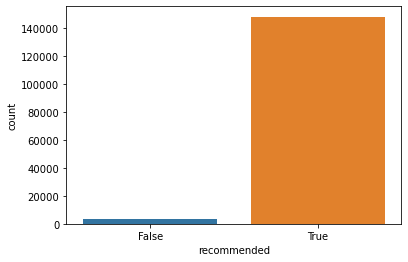

In [161]:
#checking the number of true and false in the recommended column
sns.countplot(x='recommended',data=df)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='len', ylabel='Density'>

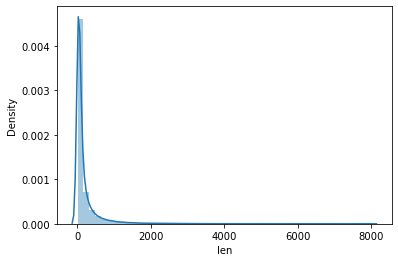

In [162]:
#checking the density of length of reviews
df['len']=df['review'].str.len()
sns.distplot(df['len'])

In [163]:
#analyzing the length of reviews
df['len'].describe()

count    151214.000000
mean        209.797810
std         529.429039
min           1.000000
25%          19.000000
50%          54.000000
75%         172.000000
max        8000.000000
Name: len, dtype: float64

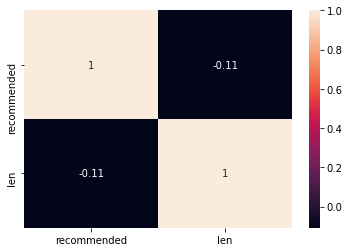

In [164]:
#checking for correlations between the length of the review and the target column
correl = df.corr()
hmap = sns.heatmap(correl, annot = True)

In [165]:
#looking for null values
df = df.dropna()
df.isnull().sum()

review         0
recommended    0
len            0
dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,review,len
recommended,,
False,51,51
True,4880,4880


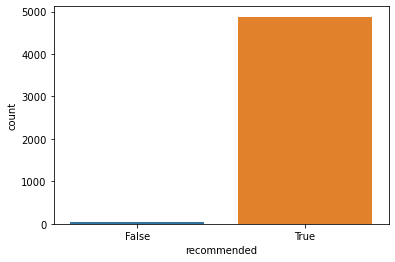

In [166]:
#positive sentiment
positive = df[df['review'].str.contains("(:\s?D|:-D|x-?D|X-?D|;\s?\)|;-\)|\(\s?;|\(-;|:\s?\)|:-\)|\(\s?:|\(-:|:\’\)|<3|:\*)")].copy()
sns.countplot(x='recommended',data=positive)
positive.groupby('recommended').count()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,review,len
recommended,,
False,34,34
True,461,461


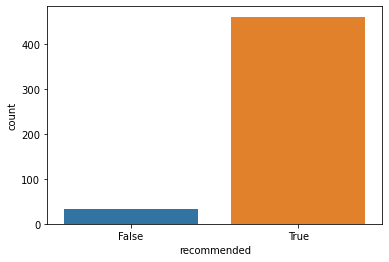

In [167]:
#negative sentiments
negative = df[df['review'].str.contains("(:\s?\(|:-\(|\)\s?:|\)-:|(:,\(|:\’\())")].copy()
sns.countplot(x='recommended',data=negative)
negative.groupby('recommended').count()

In [168]:
#looking for null values
df = df.dropna()
df.isnull().sum()

review         0
recommended    0
len            0
dtype: int64

## Step 2.2 : cleaning the database

In [169]:
#replacing emojis 
df = df.replace(regex=["(:\s?D|:-D|x-?D|X-?D|;\s?\)|;-\)|\(\s?;|\(-;|:\s?\)|:-\)|\(\s?:|\(-:|:\’\)|<3|:\*)"], value='good')
df = df.replace(regex=["(:\s?\(|:-\(|\)\s?:|\)-:|(:,\(|:\’\())"], value='sad')

In [170]:
#showing website link
df[df['review'].str.contains("http")]

,review,recommended,len
107,"[b] Alright, I am aware of how many good things have been said about the game, another positive review might be pointless. I am here just to point out some things that are rarely said and to let off steam from playing this game. I am going to divide the review in parts that I wanted to point out...",True,5888.0
763,These mods are a MUST get:Fast travel from anywhere: https://www.nexusmods.com/witcher3/mods/324/ 9000 Weight limit: https://www.nexusmods.com/witcher3/mods/3Indestructible items: https://www.nexusmods.com/witcher3/mods/342 No fall damage: https://www.nexusmods.com/witcher3/mods/352,True,283.0
1190,"Quick disclaimer. I have more bad to say about this game than good, buuuuut despite all the criticism it is a great game and a must buy IF it is on sale. DO NOT pay full price for this. The idea that in 2015 people paid 60 dollars for this is truly upsetting. Pros- Interesting world based on the...",True,3041.0
1250,https://www.youtube.com/watch?v=8ztofZ_bdWgA $14.99 Masterpiece!,True,64.0
1335,"How one of my friend have said: It is easily the best game of the decade - and I agree! I have never been a fan of RPG games but it change after playing this masterpiece. If you combine story, gameplay, graphics / visuals / effects, characters (NPCs), options you can choose from, more endings - ...",True,801.0
...,...,...,...
151047,"This is to be edited upon further playing.Pros so far:- Story is really good so far- Facial expressions are good- Gwent can be fun, but holy shit do NPCs have OP decks.- Open world is nice (Though I find it poorly done in some cases. I think I like Skyrim more overall, in terms of open worldness...",True,1937.0
151080,Thumbs up goodhttps://youtu.be/LEZkYolq5SI,True,40.0
151184,"AMD Athlon x4 750k 3.40 GHZXFX Radeon HD 77008GB RAM Despite not being able to maintain atleast 10fps on low settings with this setup, i can honestly give this game of the year, my machine however cannot as my graphics card combusted 8/10 Should have read min spec and got for ps4 instead...",True,358.0
151436,"Horrible optimization, devs mislead players, created hype by lying - showing awesome graphics 2 years ago and then what we got now? Downgraded ugly game which need beast gpu to even run at 60fps/1080p.I can barely play it on lowest at 40fps, while Gta v runs at 60fps with rare drops to 50-55.Als...",False,2784.0


In [171]:
#removing website link
def removeurl(text):
    urlfree=re.sub(r'http\S+', '', text)
    return urlfree

#storing the puntuation free text
df['review'] = df['review'].apply(lambda x:removeurl(x))

In [172]:
#removing html 
df[df['review'].str.contains("\[|\{")]

,review,recommended,len
72,---{Graphics}---☐ You forget what reality is☑ Beautiful☐ Good☐ Decent☐ Bad☐ Don‘t look too long at it☐ Paint.exe---{Gameplay}---☐ Very good☐ Good☑ Fun but repetitive☐ It‘s just gameplay☐ Mehh☐ Starring at walls is better☐ Just don‘t---{Audio}---☐ Eargasm☐ Very good☑ Good☐ Not too bad☐ Bad☐ Earra...,True,1307.0
107,"[b] Alright, I am aware of how many good things have been said about the game, another positive review might be pointless. I am here just to point out some things that are rarely said and to let off steam from playing this game. I am going to divide the review in parts that I wanted to point out...",True,5888.0
170,---{Graphics}---☐ You forget what reality is☑ Beautiful [Only beautiful beacuse in the firsts trailers the game look better]☐ Good☐ Decent☐ Bad☐ Don‘t look too long at it☐ MS-DOS---{Gameplay}---☑ Very good [Beautiful]☐ Good☐ It‘s just gameplay☐ Mehh☐ Watch paint dry instead☐ Just don't---{Audio}...,True,1214.0
233,"After 107 hours of joy, surprise, fear, sadness, and more (also a little bit of AFK), I finally finished this masterpiece (base game only, yet). There is absolutely not a single reason not to buy this game. BEST GAME EVER.---{Graphics}---☐ You forget what reality is☑ Sexy☐ Good☐ Decent☐ Bad☐ Don...",True,1432.0
279,Yes o yes one of my favorite games and is heartbreaking with the story. the graphics are pretty good and GREAT for a 2015 game. this game has the best story of any game i have played and has a good combat system. the map is HUGE and when i say huge i mean prob as big as GTA 5 map huge OR...,True,598.0
...,...,...,...
151370,"Ok....first review how the wild hunt is going on:After glorious 45 minutes being around Geralt it literally blew up the third HD-partion which we just set up for meetings with the Witcher himself (damn, he is such a VIP here *lol*) wisely knowing that this happened a couple of years ago when we ...",True,953.0
151378,"cant really enjoy it, because even with everything on ultra, it partly looks like a 2012 console game.well done, cd projekt.i guess its just another hyped game killed by ps4 / xbox underdevelopment.[h1]if you charge the full price for a pc release, make it at least look like a pc release and not...",False,414.0
151409,"[h1]Is it May 19th yet?[/h1][b]YES, IT FINALLY IS![/b]Review:At last the long awaited sequel from 2011's Witcher 2 gets on PC and let me tell you my impressions so far.Developed by CD Prokekt RED, The Witcher 3 is a third person open world RPG set in the land of Temeria.You take control of Geral...",True,2548.0
151436,"Horrible optimization, devs mislead players, created hype by lying - showing awesome graphics 2 years ago and then what we got now? Downgraded ugly game which need beast gpu to even run at 60fps/1080p.I can barely play it on lowest at 40fps, while Gta v runs at 60fps with rare drops to 50-55.Als...",False,2784.0


In [173]:
def removehtml(text):
    htmlfree=re.sub(r'\[\S+\]|\-\S+\-', '', text)
    return htmlfree

#storing the html free text
df['review'] = df['review'].apply(lambda x:removehtml(x))

In [174]:
#boxes
df[df['review'].str.contains("☐|☑")].groupby("recommended").count()

,review,len
recommended,,
True,257,257


In [175]:
#removing boxes
df = df[df['review'].str.contains("☐|☑")==False]

In [176]:
#removing short reviews
df = df[df['len']>3]

In [177]:
#looking for null values
df = df.dropna()
df.isnull().sum()

review         0
recommended    0
len            0
dtype: int64

In [178]:
#dropping the length column
df = df.drop(['len'], axis=1)

In [179]:
#checking for good score
df[df['review'].str.contains("([5-9]|10|11|12)"+"/10")]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,review,recommended
86,It's 2021. This is the first time I have played this. All of the good things that I was told about this game still hold up to this day. What an amazing game! 11/10. Recommended for everyone!,True
109,"no matter how many mods you download, Roach is still is dumb fuck10/10",True
138,Been a gamer all my life and this one is the best ive played hands down 10/10,True
162,Maybe one of the best games of history. The swords are enough to make one addicted. 10/10.,True
169,10/10,True
...,...,...
151441,Story is great Combat is funSigns are usefulQuest are fun and interestingI think this just became my favorite game10/10,True
151446,Started gameChose hardest difficultyDied to the very first encounter within seconds10/10,True
151447,*Preordered but still throws money to screen even after launch*11/10 will throw again.,True
151452,Probably game everStory - 9/10Gameplay 10/10Music - 10/10Graphics - 10/10P.S. Sandbox for screenshots,True


In [180]:
#checking for bad scores
df[df['review'].str.contains(" "+"([0-5])"+"/10")]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,review,recommended
412,"Did not enjoy this game. Main questline is too boring as it feels repetitive (In order to find someone, you have to find another, then find something for that someone and repeat). I did not enjoy the health mechanism and I would have liked a more customisable armor set where you can manually do ...",False
2680,Game's ok I guess. Youre witch or something but i got one major issue with it. At the beginning there's a dude whos looking for his brother. His brother has a dog and with your help the dog finds the lost brother. Cool story exept that even after completing the quest I CANNOT PET THE DOG. His na...,True
2831,"lost all my savings on Gwent, 0/10",True
4610,"One of the best games ever, 2/10",True
6923,"Dammm... so much quests bugged, can't receive quest items... sometimes console helps, but not always... Because of this my grade would be 4/10. Bugged quests destroy all game experience...",False
...,...,...
149978,A kid told me to fuck off 0/10 game of the year,True
150316,Poorly optimized game that crashes over and over. was able to play for a few hours when it would crash on occasion but i got to a spot in a cave and it just keeps minimizing itself and wont open up have to task manager close it. Didn't see a Early Access tag on this so what gives??? 0/10 do not ...,False
150326,"Very hard to control your character during battle(Typically you can't rely on autoaim at all, since it's totally random bugged shit)Enemys can randomly insta-attack you w/o any animation and that frustrates me much, and they also can hit you even if you dodged and your fucking hitboxes 1km away....",False
150782,"I love PC gaming, but PC gamers are some of the most obnoxious, entitled, and whiny people you will ever encounter. It's funny how you look at the PS4 and Xbox One reviews of this game and see unanimously favorable reviews from critics AND users. But when you look at the PC reviews people give 0...",True


In [181]:
#replacing scores
def remove_best(text):
    scorefree=re.sub(r"(10|11|12)"+"/10", 'best', text)
    return scorefree

def remove_good(text):
    scorefree=re.sub(r"([6-9])"+"/10", 'good', text)
    return scorefree

def remove_bad(text):
    scorefree=re.sub(r"([0-5])"+"/10", 'bad', text)
    return scorefree

In [182]:
#replacing perfect score with best
df['review'] = df['review'].apply(lambda x:remove_best(x))

In [183]:
#replacing good score with good
df['review'] = df['review'].apply(lambda x:remove_good(x))

In [184]:
#replacing bad score with bad
df['review'] = df['review'].apply(lambda x:remove_bad(x))

In [185]:
#defining the function to remove punctuation
def removepunctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['review'] = df["review"].apply(lambda x:removepunctuation(x))

In [186]:
#converting to lower case
df['review'] = df['review'].apply(lambda x: x.lower())

In [187]:
#replacing repeating characters
re.sub(r"(.)\1+", r"\1\1", "sooo cool")

'soo cool'

In [188]:
#removing special caracters
def removespecial(text):
    specialfree=re.sub('[^a-zA-Z]+', ' ', text)
    return specialfree

df['review'] = df['review'].apply(lambda x:removespecial(x))

In [189]:
#removing repeating characters
def removemultiple(text):
    multiplefree=re.sub(r"(.)\1+", r"\1\1", text)
    return multiplefree

df['review'] = df['review'].apply(lambda x:removemultiple(x))

In [190]:
#replacing most used slang words
df = df.replace(regex=["gg"], value='good game')
df = df.replace(regex=["oh my god"], value='omg')

In [191]:
df[df['review'].str.contains("lol")]

,review,recommended
79,cant believe i havent rated this so far lol good,True
280,not normally into wizards and stuff honestly find it lazy writing because any problem or solution can be explained by magic lol but this game got morbid right quick and i dig it,True
313,playing a few hours into this and i knew what cyberpunk would be lolthey try but they dont even get close,False
611,just get it lol dont even think about it,True
1057,open world with lots of different interesting outcomes even for side quests gotta be one of the best open world games out there captures the medieval world pretty well even teaches you how people used to treat boils and how girls used to make eyeliners with egood game yolks lol also the bestiary...,True
...,...,...
151066,hours in and having a blast so far so good and so worth the purchase ok its been awhile since last review this game is so worth it yes im finally getting just a little board after hours lol,True
151102,great game loving it so far and have had no issues and running everything on maxed out settings with vsync on and that means with hairworks on as well and i hit fps with no issues havent checked fps during cut scenes yet but honestly heard someone mad about cut scenes dropping to around fps duri...,True
151110,you know im honestly surprised how little this got mentioned in the comments i even asked one of my friends why he bought it on steam in the first place but the truth of the matter was that he just didnt know that there were other better avenues to buy this beauty he regretted it a fair bit when...,True
151370,okfirst review how the wild hunt is going onafter glorious minutes being around geralt it literally blew up the third hdpartion which we just set up for meetings with the witcher himself damn he is such a vip here lol wisely knowing that this happened a couple of years ago when we first met and ...,True


In [192]:
#removing stopwords
stopwords = nltk.corpus.stopwords.words('english')
#defining the function to remove stopwords from tokenized text
def removestopwords(text):
    no_stop_words= " ".join([i for i in text.split() if i not in stopwords])
    return no_stop_words

#data['review'] = data['review'].apply(lambda x:removestopwords(x))

In [193]:
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text.split()])
    return lemm_text

#data['review'].apply(lambda x:lemmatizer(x))

## Step 2.3 : first data analysis

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

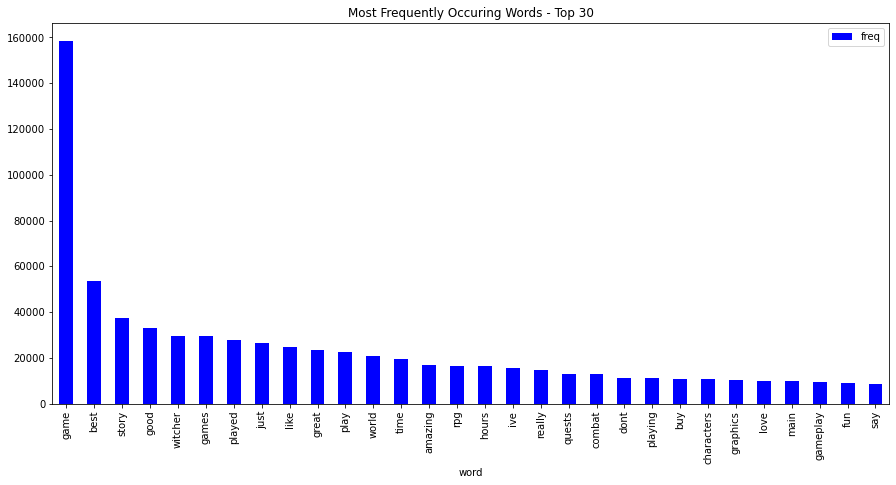

In [194]:
#showing the most frequent words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

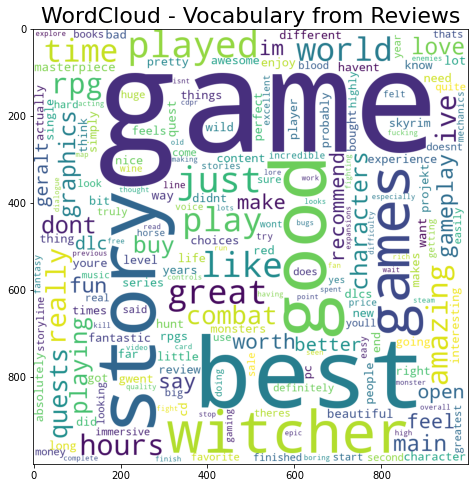

In [195]:
#generating a worldcloud from the unigrams
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

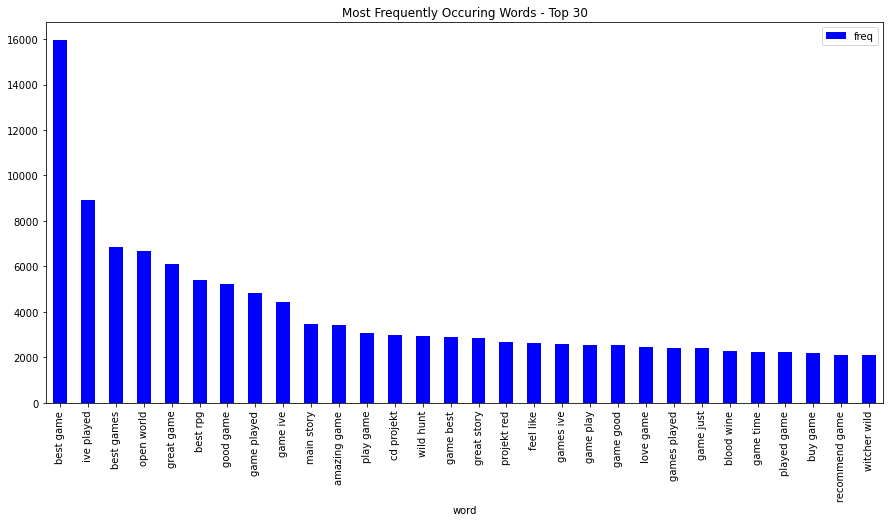

In [196]:
#showing the most frequent bigrams
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2)) 
words = cv.fit_transform(df.review)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

# Step 3 : Data analysis

## Step 3.1 : preparing test and training dataset

In [197]:
#creation of the balanced training dataset
def cre_balanced(number,df):
  pos = df[df['recommended']==True].copy()
  pos_s = pos.sample(n=number)
  neg = df[df['recommended']==False].copy()
  neg_s = neg.sample(n=number)
  df = pd.concat([neg_s,pos_s])
  return df

In [198]:
def cre_imbalanced(number,df):
  df = df.sample(n=number)
  return df

In [199]:
def cre_balanced2(number,df):
  pos = df[df['recommended']==True].copy()
  pos_s = pos.sample(n=2*number)
  neg = df[df['recommended']==False].copy()
  neg_s = neg.sample(n=number)
  df = pd.concat([neg_s,pos_s])
  return df

In [200]:

def transform(df, vec):
  le = preprocessing.LabelEncoder()
  df.iloc[:,1] = le.fit_transform(df.iloc[:,1])
  x = df.iloc[:,0]
  y = df.iloc[:,1]
  X_vec = vec.fit_transform(x)
  return(X_vec,y)

In [201]:
transform(cre_balanced(3000,df), TfidfVectorizer() )

(<6000x20712 sparse matrix of type '<class 'numpy.float64'>'
 	with 256838 stored elements in Compressed Sparse Row format>,
 149174    0
 136685    0
 107725    0
 14190     0
 18497     0
          ..
 78672     1
 35138     1
 136874    1
 3125      1
 126740    1
 Name: recommended, Length: 6000, dtype: int64)

In [202]:
def perform(x_train, x_test, y_train, y_test,model,bool=False,convert=False):
  start = time()
  if convert : 
    model.fit(x_train.toarray(),y_train)
  else : 
    model.fit(x_train,y_train)
  end = time() - start
  predictions = model.predict(x_test.toarray())
  matrix=confusion_matrix(y_test,predictions)
  score=accuracy_score(y_test,predictions)
  report=classification_report(y_test,predictions)
  print("end : ",end)
  print("matrix : ",matrix)
  print("accuracy score : " ,score)
  print("classification report : ",report)
  if bool : 
    print("training set : '", roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    print("test set : '",roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

## Step 3.2 : Results - balanced test

In [203]:
#create a balanced dataset
df1 = cre_balanced(3000,df)
X_vec,y=transform(cre_balanced(3000,df1), TfidfVectorizer()) 
x_train, x_test, y_train, y_test = train_test_split(X_vec, y,test_size=0.2)

In [204]:
#logistic regression
perform(x_train, x_test, y_train, y_test,LogisticRegression(max_iter=1000))

end :  0.11867070198059082
matrix :  [[556  69]
 [ 78 497]]
accuracy score :  0.8775
classification report :                precision    recall  f1-score   support

           0       0.88      0.89      0.88       625
           1       0.88      0.86      0.87       575

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



In [205]:
#support vector machine
perform(x_train, x_test, y_train, y_test,svm.SVC(kernel='linear', C = 1.0),False)

end :  2.484753131866455
matrix :  [[566  59]
 [ 67 508]]
accuracy score :  0.895
classification report :                precision    recall  f1-score   support

           0       0.89      0.91      0.90       625
           1       0.90      0.88      0.89       575

    accuracy                           0.90      1200
   macro avg       0.90      0.89      0.89      1200
weighted avg       0.90      0.90      0.89      1200



In [206]:
#decision tree
perform(x_train, x_test, y_train, y_test,tree.DecisionTreeClassifier(),True)

end :  0.7563080787658691
matrix :  [[482 143]
 [117 458]]
accuracy score :  0.7833333333333333
classification report :                precision    recall  f1-score   support

           0       0.80      0.77      0.79       625
           1       0.76      0.80      0.78       575

    accuracy                           0.78      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200

training set : ' 0.9999351492132393
test set : ' 0.7931798260869565


In [207]:
#Random forest
perform(x_train, x_test, y_train, y_test,RandomForestClassifier(n_estimators=200,criterion='entropy'),False)

end :  12.675679922103882
matrix :  [[537  88]
 [109 466]]
accuracy score :  0.8358333333333333
classification report :                precision    recall  f1-score   support

           0       0.83      0.86      0.85       625
           1       0.84      0.81      0.83       575

    accuracy                           0.84      1200
   macro avg       0.84      0.83      0.84      1200
weighted avg       0.84      0.84      0.84      1200



## Step 3.3 : Results - unbalanced test

In [208]:
#imbalanced dataset
df2 = cre_imbalanced(3000,df)
X_vec,y=transform(df2, TfidfVectorizer()) 
x_train, x_test, y_train, y_test = train_test_split(X_vec, y,test_size=0.2)

In [209]:
#logistic regression
perform(x_train, x_test, y_train, y_test,LogisticRegression(max_iter=1000))

end :  0.04198408126831055
matrix :  [[  0  16]
 [  0 584]]
accuracy score :  0.9733333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.97      1.00      0.99       584

    accuracy                           0.97       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.95      0.97      0.96       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [210]:
#support vector machine
perform(x_train, x_test, y_train, y_test,svm.SVC(kernel='linear', C = 1.0),False)

end :  0.1808619499206543
matrix :  [[  0  16]
 [  0 584]]
accuracy score :  0.9733333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.97      1.00      0.99       584

    accuracy                           0.97       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.95      0.97      0.96       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
#Random forest
perform(x_train, x_test, y_train, y_test,RandomForestClassifier(n_estimators=200,criterion='entropy'),False)

end :  1.7085750102996826
matrix :  [[  0  16]
 [  0 584]]
accuracy score :  0.9733333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.97      1.00      0.99       584

    accuracy                           0.97       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.95      0.97      0.96       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step 3.4 : hyperparameterization

In [155]:
from sklearn.model_selection import GridSearchCV

In [212]:
df3=cre_balanced2(3000,df)

In [213]:
#parameter tuning for linear kernel
param_grid = {'C': [0.1,1, 10, 100]}

In [214]:
x_train, x_test, y_train, y_test = train_test_split(X_vec, y,test_size=0.2)
grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ...............................................C=10; total time=   0.3s
[CV] END ........................................

GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100]}, verbose=2)

In [215]:
print(grid.best_estimator_)

SVC(C=0.1)


In [216]:
grid_predictions = grid.predict(x_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[  0  13]
 [  0 587]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [217]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=10), False)

end :  0.18192815780639648
matrix :  [[  5   8]
 [  2 585]]
accuracy score :  0.9833333333333333
classification report :                precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.99      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.85      0.69      0.75       600
weighted avg       0.98      0.98      0.98       600



In [218]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=1), False, False)

end :  0.18822312355041504
matrix :  [[  1  12]
 [  1 586]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.74      0.54      0.56       600
weighted avg       0.97      0.98      0.97       600



In [219]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=0.1), False,False)

end :  0.17777109146118164
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [220]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=1), False, False)

end :  0.18467020988464355
matrix :  [[  1  12]
 [  1 586]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.74      0.54      0.56       600
weighted avg       0.97      0.98      0.97       600



In [221]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=0.001), False, False)

end :  0.06658697128295898
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [222]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=5), False, False)

end :  0.19193792343139648
matrix :  [[  4   9]
 [  2 585]]
accuracy score :  0.9816666666666667
classification report :                precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.83      0.65      0.71       600
weighted avg       0.98      0.98      0.98       600



In [223]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=10), False, False)

end :  0.18066978454589844
matrix :  [[  5   8]
 [  2 585]]
accuracy score :  0.9833333333333333
classification report :                precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.99      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.85      0.69      0.75       600
weighted avg       0.98      0.98      0.98       600



In [224]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=100), False, False)

end :  0.15727996826171875
matrix :  [[  5   8]
 [  0 587]]
accuracy score :  0.9866666666666667
classification report :                precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.99      1.00      0.99       587

    accuracy                           0.99       600
   macro avg       0.99      0.69      0.77       600
weighted avg       0.99      0.99      0.98       600



In [225]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='linear',C=0.01), False, False)

end :  0.1406087875366211
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [226]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='poly',C=1, degree=2), False, False)

end :  0.43230700492858887
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [227]:
perform(x_train, x_test, y_train, y_test, svm.SVC(kernel='sigmoid',C=0.01),False,False)

end :  0.1135401725769043
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [228]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l2',C=1),False,False)

end :  0.0441899299621582
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [229]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l2',C=20),True,False)

end :  0.19405889511108398
matrix :  [[  1  12]
 [  0 587]]
accuracy score :  0.98
classification report :                precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.99      0.54      0.57       600
weighted avg       0.98      0.98      0.97       600

training set : ' 1.0
test set : ' 0.9446992530467828


In [230]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l2',C=10),True,False)

end :  0.06485986709594727
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600

training set : ' 0.9999754291704888
test set : ' 0.9492858078888744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l1',C=1,solver='liblinear'),True,False)

end :  0.011520147323608398
matrix :  [[  1  12]
 [  1 586]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.74      0.54      0.56       600
weighted avg       0.97      0.98      0.97       600

training set : ' 0.9089446009697287
test set : ' 0.9169178351461145


In [232]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l1',C=1,solver='saga'),True,False)

end :  0.15997314453125
matrix :  [[  1  12]
 [  1 586]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.74      0.54      0.56       600
weighted avg       0.97      0.98      0.97       600

training set : ' 0.9092066898178482
test set : ' 0.9175730572664134


In [234]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l1',C=10,solver='liblinear'),True,False)

end :  0.016823768615722656
matrix :  [[  2  11]
 [  3 584]]
accuracy score :  0.9766666666666667
classification report :                precision    recall  f1-score   support

           0       0.40      0.15      0.22        13
           1       0.98      0.99      0.99       587

    accuracy                           0.98       600
   macro avg       0.69      0.57      0.61       600
weighted avg       0.97      0.98      0.97       600

training set : ' 0.9999918097234962
test set : ' 0.8845498624033548


In [235]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=1000, penalty='l1',C=50,solver='liblinear'),True,False)

end :  0.022295713424682617
matrix :  [[  3  10]
 [  3 584]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.50      0.23      0.32        13
           1       0.98      0.99      0.99       587

    accuracy                           0.98       600
   macro avg       0.74      0.61      0.65       600
weighted avg       0.97      0.98      0.97       600

training set : ' 1.0
test set : ' 0.8681693093958852


In [236]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=10000),True,False)

end :  0.04215598106384277
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600

training set : ' 0.9932594024374264
test set : ' 0.949416852312934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [237]:
perform(x_train, x_test, y_train, y_test, LogisticRegression(max_iter=10000,C=10),True,False)

end :  0.0641319751739502
matrix :  [[  0  13]
 [  0 587]]
accuracy score :  0.9783333333333334
classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600

training set : ' 0.9999754291704888
test set : ' 0.9492858078888744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
